In [29]:
import glob 
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
%matplotlib inline
sns.set()

from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout,Bidirectional,GRU,Reshape,Input,InputLayer,Activation
import tensorflow as tf
import tensorflow.keras
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
from sklearn.metrics import roc_curve,confusion_matrix,roc_auc_score, precision_score, recall_score, accuracy_score

In [30]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
#Getting X
path_x = '/content/drive/My Drive/transformer_code/data_copy/X.npy'
X = np.load(path_x)
print(X.shape)

(1606, 200, 15, 4)


In [32]:
#Getting Y
path_save = '/content/drive/My Drive/transformer_code/data_copy/Y.csv'
Y = pd.read_csv(path_save).T

In [33]:
#Splite data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [34]:
# Model building by CNN + GRU
model = Sequential()
model.add(InputLayer(input_shape=(200,15,4,1)))
model.add(Conv2D(30, kernel_size=3, 
activation='relu',
input_shape = (15,4,1)
))
model.add(Conv2D(60, kernel_size=(4,2),
activation='relu' ))
model.add(Flatten())
model.add(Reshape((200,600)))
model.add(Dropout(0.4)) # 03/08/2002 -Chen 
model.add(Bidirectional(GRU(units=80, input_shape=(200,600),activation='relu',return_sequences=True)))
model.add(Dropout(0.4))
model.add(Dense(1,activation = 'sigmoid'))
#model.add(Activation( activation = 'sigmoid'))
model.compile(loss='BinaryCrossentropy',
              optimizer='ADAM',
              metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 200, 13, 2, 30)    300       
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 10, 1, 60)    14460     
                                                                 
 flatten_1 (Flatten)         (None, 120000)            0         
                                                                 
 reshape_1 (Reshape)         (None, 200, 600)          0         
                                                                 
 dropout_2 (Dropout)         (None, 200, 600)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 160)         327360    
 nal)                                                            
                                                      

In [36]:
#Training model by 50 epochs, 21 batch size 
epochs = 60
#Evaluating the model by recall and precision value
history = model.fit(X_train,Y_train, batch_size = 21, epochs = epochs, validation_data=[X_test,Y_test])

Epoch 1/60
62/62 [==============================] - 61s 993ms/step - loss: 0.2784 - accuracy: 0.9197 - recall_1: 0.0024 - precision_1: 0.8596 - val_loss: 0.2260 - val_accuracy: 0.9295 - val_recall_1: 0.0759 - val_precision_1: 0.7191
Epoch 2/60
62/62 [==============================] - 54s 878ms/step - loss: 0.2175 - accuracy: 0.9267 - recall_1: 0.1552 - precision_1: 0.7017 - val_loss: 0.1838 - val_accuracy: 0.9377 - val_recall_1: 0.1847 - val_precision_1: 0.8712
Epoch 3/60
62/62 [==============================] - 54s 867ms/step - loss: 0.1927 - accuracy: 0.9374 - recall_1: 0.3211 - precision_1: 0.7639 - val_loss: 0.1644 - val_accuracy: 0.9455 - val_recall_1: 0.3572 - val_precision_1: 0.7911
Epoch 4/60
62/62 [==============================] - 54s 874ms/step - loss: 0.1762 - accuracy: 0.9429 - recall_1: 0.4010 - precision_1: 0.7841 - val_loss: 0.1534 - val_accuracy: 0.9490 - val_recall_1: 0.3646 - val_precision_1: 0.8705
Epoch 5/60
62/62 [==============================] - 54s 868ms/step -

In [40]:
# Getting recall and precision value
recall,precision,val_recall,val_precision =  history.history['recall_1'], history.history['precision_1'],history.history['val_recall_1'], history.history['val_precision_1']


In [41]:
model.save('/content/drive/My Drive/transformer_code/model/my_model_2')

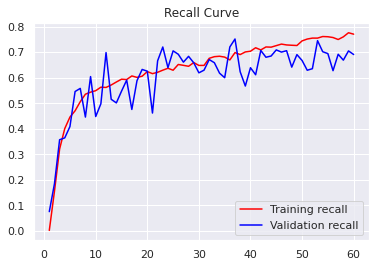

In [44]:
# Plot the recall curve
plt.title('Recall Curve')
epochs = range (1,len(recall) + 1)
plt.plot(epochs, recall, 'red', label='Training recall')
plt.plot(epochs, val_recall, 'blue', label='Validation recall')
plt.legend()
plt.show()

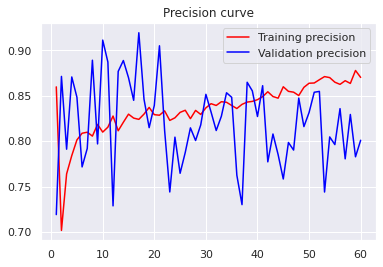

In [45]:
#Plot the precision curve
plt.title('Precision curve')
plt.plot(epochs, precision, 'red', label='Training precision')
plt.plot(epochs, val_precision, 'blue', label='Validation precision')
plt.legend()
plt.show()

Comparing predicted value and evaluated value

In [48]:
# Getting Y
y_true = Y_test.values.ravel() # -- test value
y_probas = model.predict(X_test).reshape(-1,200).ravel() # -- predicted value
# enconding the array by sigmoid algorithm
for i in range(len(y_probas)):
  if y_probas[i] < 0.5:
     y_probas[i] = 0
  else:
     y_probas[i] = 1

Total values :64400
[[ 3287  1472]
 [  817 58824]]


Text(30.5, 0.5, 'ground')

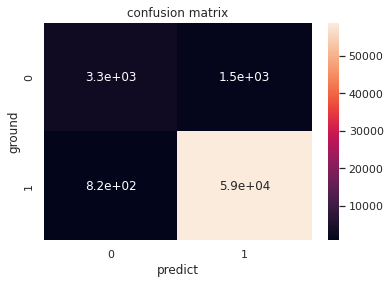

In [49]:
#Confusion matrix
print("Total values :"+str(len(y_probas)))
f,ax=plt.subplots()
C2= confusion_matrix(y_true, y_probas,labels=[1,0])
print(C2) 
sns.heatmap(C2,annot=True,ax=ax) 
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('ground') #y轴

In [50]:
# evaluating result by precision and recall rate
p = precision_score(y_true, y_probas)
r = recall_score(y_true, y_probas)
print("precision is "+str(p))
print("recall is "+str(r))


precision is 0.8009259259259259
recall is 0.6906913217062408
